In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT & IMPORT THƯ VIỆN
# -- Chạy xong bước 1 phải reset session rồi mới import thư viện
# ==============================================================================
!pip install --upgrade scipy scikit-learn pandas --quiet
!pip install transformers datasets sacremoses pysrt underthesea \
             sacrebleu unbabel-comet tqdm accelerate evaluate \
             sentencepiece torch "numpy<2.0.0" --quiet

print("Đã cài đặt xong thư viện!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 

In [ ]:
import os
import glob
import random
import shutil
import pandas as pd
import pysrt
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from underthesea import word_tokenize
import evaluate
from transformers import MBart50TokenizerFast, MBartForConditionalGeneration

In [ ]:
# ==============================================================================
# BƯỚC 2: CẤU HÌNH HỆ THỐNG & ĐƯỜNG DẪN
# ==============================================================================
MAIN_WORKSPACE = '/content/drive/MyDrive/Colab_Notebooks/ITP'
DICT_PATH = os.path.join(MAIN_WORKSPACE, 'workspace_mBART50', 'chinese-hanviet-cognates.tsv')
MAIN_DATASET_ROOT = os.path.join(MAIN_WORKSPACE, 'data_multi-webs')

# Nơi lưu dữ liệu đã xử lý để dùng lại sau này
DATA_SPLIT_DIR = os.path.join(MAIN_WORKSPACE, 'data_split_mBART50')
os.makedirs(DATA_SPLIT_DIR, exist_ok=True)

# Nơi lưu checkpoint và model cuối
OUTPUT_DIR = os.path.join(MAIN_WORKSPACE, 'workspace_mBART50', "zh-vi-historical-model")
FINAL_MODEL_DIR = os.path.join(MAIN_WORKSPACE, 'workspace_mBART50', "final_model")

# THAM SỐ ISS (Intelligent Subtitle Segmentation)
ISS_EPSILON = 500  # Sai số cho phép 500ms khi căn chỉnh

# Kiểm tra GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Đã tìm thấy GPU: {torch.cuda.get_device_name(0)}")
    USE_FP16 = True # Dùng GPU thì bật FP16 cho nhanh
else:
    device = torch.device("cpu")
    print("Không tìm thấy GPU, đang chạy trên CPU")
    USE_FP16 = False

Đã tìm thấy GPU: Tesla T4


In [ ]:
# ==============================================================================
# BƯỚC 3: HỆ THỐNG ISS (ALIGNMENT) & SBA (AUGMENTATION)
# ==============================================================================

def load_dictionary(file_path):
    print(f"Đang đọc từ điển: {file_path}")
    try:
        df = pd.read_csv(file_path, sep='\t').dropna(subset=['word', 'hanviet'])
        return df['word'].astype(str).tolist(), df['hanviet'].astype(str).tolist()
    except Exception as e:
        print(f"Lỗi đọc từ điển: {e}")
        return [], []

def clean_text(text):
    if not isinstance(text, str): return ""
    return text.replace('\n', ' ').replace('<i>', '').replace('</i>', '').strip()

def align_subtitles_by_time(zh_path, vi_path, epsilon=500):
    try:
        subs_zh = pysrt.open(zh_path, encoding='utf-8')
        subs_vi = pysrt.open(vi_path, encoding='utf-8')
    except Exception as e:
        return [], []

    src_aligned, tgt_aligned = [], []
    vi_idx = 0
    max_vi = len(subs_vi)

    for zh_sub in subs_zh:
        zh_start = zh_sub.start.ordinal
        best_match = None
        min_diff = float('inf')
        temp_idx = vi_idx
        while temp_idx < max_vi:
            vi_sub = subs_vi[temp_idx]
            vi_start = vi_sub.start.ordinal
            diff = abs(zh_start - vi_start)
            if vi_start > zh_sub.end.ordinal + epsilon: break
            if diff <= epsilon:
                if diff < min_diff:
                    min_diff = diff
                    best_match = vi_sub
                    vi_idx = temp_idx
            temp_idx += 1
        if best_match:
            src_aligned.append(clean_text(zh_sub.text))
            tgt_aligned.append(clean_text(best_match.text))
    return src_aligned, tgt_aligned

def sentence_boundary_augmentation(src_list, tgt_list, merge_prob=0.3):
    aug_src, aug_tgt = [], []
    i = 0
    while i < len(src_list):
        if i < len(src_list) - 1 and random.random() < merge_prob:
            s1, s2 = src_list[i], src_list[i+1]
            t1, t2 = tgt_list[i], tgt_list[i+1]
            aug_src.append(s1.rstrip("。，！？…") + " " + s2)
            aug_tgt.append(t1 + " " + t2)
            i += 2
        else:
            aug_src.append(src_list[i])
            aug_tgt.append(tgt_list[i])
            i += 1
    return aug_src, aug_tgt

def process_and_load_data(base_dataset_path, dict_path):
    print(f"Đang quét và chạy ISS Alignment tại: {base_dataset_path}")
    film_src, film_tgt = [], []

    if os.path.exists(base_dataset_path):
        film_dirs = [d.path for d in os.scandir(base_dataset_path) if d.is_dir()]

        for film_dir in tqdm(film_dirs, desc="Processing Films"):
            zh_folder = os.path.join(film_dir, 'zh')
            vi_folder = os.path.join(film_dir, 'vi')

            # Kiểm tra folder tồn tại
            if not (os.path.exists(zh_folder) and os.path.exists(vi_folder)):
                continue

            # Lấy danh sách file .zh.srt
            zh_files = glob.glob(os.path.join(zh_folder, "*.zh.srt"))

            for zh_path in zh_files:
                zh_filename = os.path.basename(zh_path)

                if zh_filename.endswith(".zh.srt"):
                    vi_filename = zh_filename.replace(".zh.srt", ".vi.srt")
                    candidate_path = os.path.join(vi_folder, vi_filename)

                    if os.path.exists(candidate_path):
                        vi_path = candidate_path
                        # In ra để bạn yên tâm là nó đã tìm thấy cặp
                        # print(f"Match: {zh_filename} <-> {vi_filename}")
                    else:
                        vi_path = None
                else:
                    vi_path = None
                # --- [HẾT PHẦN CHỈNH SỬA] ---

                if vi_path:
                    raw_s, raw_t = align_subtitles_by_time(zh_path, vi_path, epsilon=ISS_EPSILON)
                    if raw_s:
                        s_proc, t_proc = sentence_boundary_augmentation(raw_s, raw_t, merge_prob=0.3)
                        film_src.extend(s_proc)
                        film_tgt.extend(t_proc)

    print(f"-> Tổng số câu phim sau xử lý: {len(film_src):,}")
    dict_src, dict_tgt = load_dictionary(dict_path)
    return film_src + dict_src, film_tgt + dict_tgt

In [ ]:
# ==============================================================================
# BƯỚC 4: CHUẨN BỊ DATASET (TRAIN / VALIDATION / TEST)
# ==============================================================================
train_src_path = os.path.join(DATA_SPLIT_DIR, 'train.zh')

# Kiểm tra dữ liệu cũ
if not os.path.exists(train_src_path):
    print("Chưa tìm thấy dữ liệu đã xử lý. Bắt đầu pipeline mới...")
    full_src, full_tgt = process_and_load_data(MAIN_DATASET_ROOT, DICT_PATH)

    if len(full_src) == 0:
        raise ValueError("Không tìm thấy dữ liệu nào! Kiểm tra lại đường dẫn.")

    df = pd.DataFrame({'zh': full_src, 'vi': full_tgt})

    # 1. Chia Train (80%) và Temp (20%)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

    # 2. Chia Temp thành Validation (10%) và Test (10%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Lưu 6 file riêng biệt
    def save_split(df, name):
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.zh'), 'w') as f: f.write('\n'.join(df['zh']))
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.vi'), 'w') as f: f.write('\n'.join(df['vi']))

    save_split(train_df, 'train')
    save_split(val_df, 'validation')
    save_split(test_df, 'test')

    print(f"Đã chia dữ liệu: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    print("Đã lưu vào folder data_split.")
else:
    print("Tìm thấy dữ liệu cũ, bỏ qua bước xử lý thô.")

# Load vào DatasetDict từ các file riêng biệt
data_files = {
    "train": {"zh": os.path.join(DATA_SPLIT_DIR, 'train.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'train.vi')},
    "validation": {"zh": os.path.join(DATA_SPLIT_DIR, 'validation.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'validation.vi')},
    "test": {"zh": os.path.join(DATA_SPLIT_DIR, 'test.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'test.vi')}
}

def load_custom_dataset():
    def read_txt(path):
        with open(path, 'r', encoding='utf-8') as f: return [l.strip() for l in f]

    return DatasetDict({
        'train': Dataset.from_dict({'zh': read_txt(data_files['train']['zh']), 'vi': read_txt(data_files['train']['vi'])}),
        'validation': Dataset.from_dict({'zh': read_txt(data_files['validation']['zh']), 'vi': read_txt(data_files['validation']['vi'])}),
        'test': Dataset.from_dict({'zh': read_txt(data_files['test']['zh']), 'vi': read_txt(data_files['test']['vi'])})
    })

raw_datasets = load_custom_dataset()
print("Cấu trúc Dataset:", raw_datasets)

Chưa tìm thấy dữ liệu đã xử lý. Bắt đầu pipeline mới...
Đang quét và chạy ISS Alignment tại: /content/drive/MyDrive/Colab_Notebooks/ITP/data_multi-webs


Processing Films:   0%|          | 0/8 [00:00<?, ?it/s]

-> Tổng số câu phim sau xử lý: 26,224
Đang đọc từ điển: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace_mBART50/chinese-hanviet-cognates.tsv
Đã chia dữ liệu: Train=21869, Val=4686, Test=4687
Đã lưu vào folder data_split.
Cấu trúc Dataset: DatasetDict({
    train: Dataset({
        features: ['zh', 'vi'],
        num_rows: 21869
    })
    validation: Dataset({
        features: ['zh', 'vi'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['zh', 'vi'],
        num_rows: 4687
    })
})



PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)


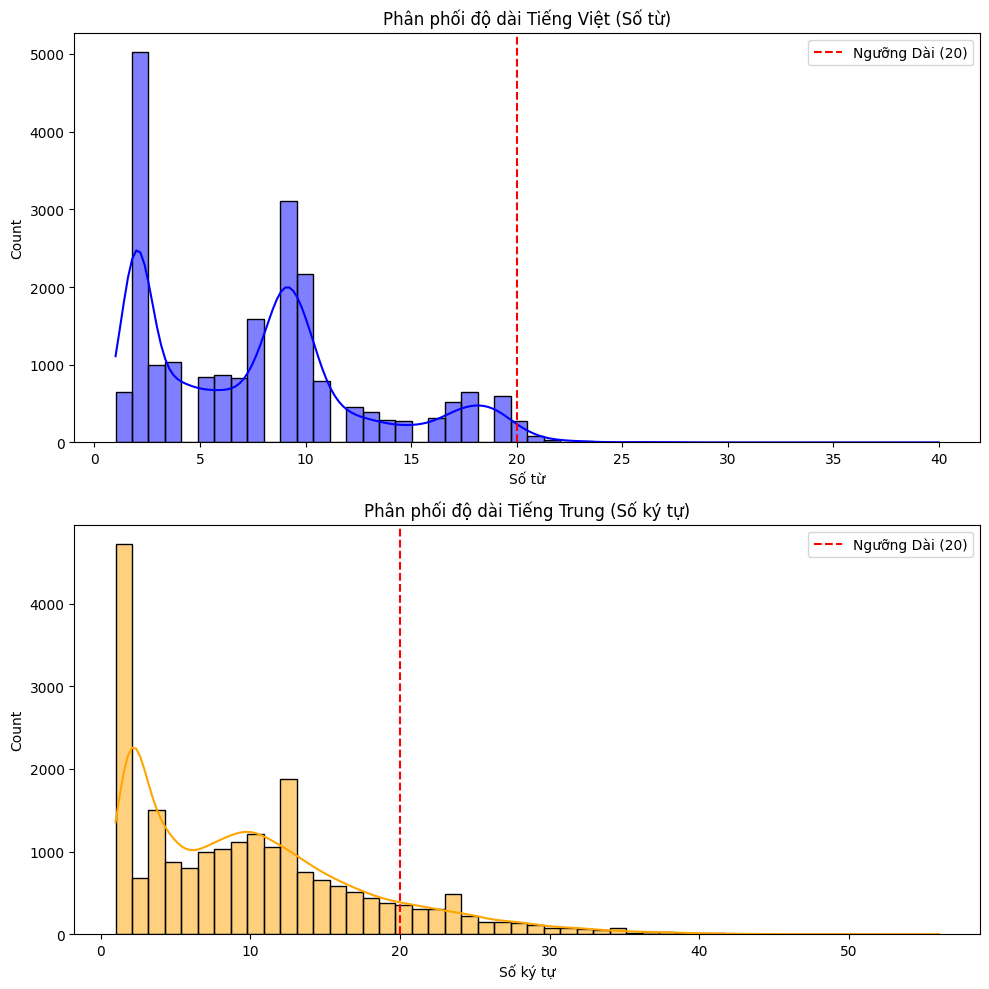


[THỐNG KÊ CHI TIẾT]
Số lượng câu dài (> 20) Tiếng Việt: 170 / 21869
Số lượng câu dài (> 20) Tiếng Trung: 2329 / 21869


In [ ]:
# ==============================================================================
# TRỰC QUAN HÓA DỮ LIỆU
# ==============================================================================
def visualize_bilingual_data(dataset):
    # Lấy mẫu tập train
    df_vis = pd.DataFrame(dataset['train'][:])

    print("\n" + "="*50)
    print("PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)")
    print("="*50)

    # 1. Tính độ dài
    # Tiếng Việt: Đếm số từ (Words)
    df_vis['vi_len'] = df_vis['vi'].astype(str).apply(lambda x: len(x.split()))
    # Tiếng Trung: Đếm số ký tự (Characters)
    df_vis['zh_len'] = df_vis['zh'].astype(str).apply(len)

    # 2. Phân loại (giữ lại phần này cho mục đích thống kê text)
    LONG_THRESHOLD = 20

    def categorize(length):
        if length < 10: return 'Ngắn (<10)'
        elif length <= LONG_THRESHOLD: return f'Trung bình (10-{LONG_THRESHOLD})'
        else: return f'Dài (>{LONG_THRESHOLD})'

    df_vis['cat_vi'] = df_vis['vi_len'].apply(categorize)
    df_vis['cat_zh'] = df_vis['zh_len'].apply(categorize)

    # 3. Vẽ biểu đồ (Chỉ 1 cột histogram cho mỗi ngôn ngữ)
    # Sử dụng subplots với 2 hàng, 1 cột
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # --- Hàng 1: Tiếng Việt ---
    # Hist
    sns.histplot(df_vis['vi_len'], bins=50, kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Phân phối độ dài Tiếng Việt (Số từ)')
    axes[0].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[0].legend()
    axes[0].set_xlabel('Số từ')

    # --- Hàng 2: Tiếng Trung ---
    # Hist
    sns.histplot(df_vis['zh_len'], bins=50, kde=True, color='orange', ax=axes[1])
    axes[1].set_title('Phân phối độ dài Tiếng Trung (Số ký tự)')
    axes[1].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[1].legend()
    axes[1].set_xlabel('Số ký tự')

    plt.tight_layout()
    plt.show()

    # In thống kê text
    print(f"\n[THỐNG KÊ CHI TIẾT]")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Việt: {len(df_vis[df_vis['vi_len'] > LONG_THRESHOLD])} / {len(df_vis)}")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Trung: {len(df_vis[df_vis['zh_len'] > LONG_THRESHOLD])} / {len(df_vis)}")

# Thay thế lệnh gọi hàm cũ bằng hàm mới:
visualize_bilingual_data(raw_datasets)

In [ ]:
# ==============================================================================
# BƯỚC 6: TOKENIZATION & MODEL SETUP
# ==============================================================================
model_checkpoint = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBart50TokenizerFast.from_pretrained(model_checkpoint, src_lang="zh_CN", tgt_lang="vi_VN")
model = MBartForConditionalGeneration.from_pretrained(model_checkpoint)
model.config.forced_bos_token_id = tokenizer.lang_code_to_id["vi_VN"]

def preprocess_function(examples):
    model_inputs = tokenizer(examples["zh"], max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["vi"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, load_from_cache_file=False)

Map:   0%|          | 0/21869 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4686 [00:00<?, ? examples/s]

Map:   0%|          | 0/4687 [00:00<?, ? examples/s]

In [ ]:
# ==============================================================================
# Chỉ chạy khi muốn training lại mô hình
# ==============================================================================
import shutil
import os

# 1. Xác định thư mục chứa checkpoint
output_dir_path = OUTPUT_DIR

# 2. Xóa toàn bộ thư mục output cũ để đảm bảo sạch sẽ 100%
if os.path.exists(output_dir_path):
    try:
        print(f"   -> Đang xóa thư mục cũ: {output_dir_path}")
        shutil.rmtree(output_dir_path) # Lệnh này xóa cực mạnh, xóa cả folder con
        print("   -> Đã xóa sạch thành công!")
    except Exception as e:
        print(f"   -> Không xóa được (Lỗi quyền hoặc Drive): {e}")
else:
    print("   -> Thư mục đã sạch hoặc chưa tồn tại, không cần xóa.")

# 3. Tạo lại thư mục rỗng
os.makedirs(output_dir_path, exist_ok=True)
print(f"   -> Đã tạo thư mục mới tại: {output_dir_path}")

   -> Thư mục đã sạch hoặc chưa tồn tại, không cần xóa.
   -> Đã tạo thư mục mới tại: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace_mBART50/zh-vi-historical-model


In [ ]:
# ==============================================================================
# BƯỚC 7: TRAINING (ĐÃ SỬA LỖI TÊN THAM SỐ)
# ==============================================================================

def clean_checkpoint_for_resume(output_dir):
    checkpoints = glob.glob(os.path.join(output_dir, "checkpoint-*"))
    if not checkpoints: return None
    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"Đang kiểm tra checkpoint: {latest_ckpt}")
    garbage_files = ["scaler.pt", "rng_state.pth"]
    for gf in garbage_files:
        path = os.path.join(latest_ckpt, gf)
        if os.path.exists(path):
            try:
                os.remove(path)
                print(f"   -> Đã xóa file gây lỗi: {gf}")
            except: pass
    return latest_ckpt

# Cấu hình Train
args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    weight_decay=0.02,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=USE_FP16, # Tự động bật tắt theo GPU
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], # Đánh giá trên file Validation
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)

/tmp/ipython-input-1996481669.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Tự động tìm và sửa checkpoint trước khi train
resume_ckpt = clean_checkpoint_for_resume(OUTPUT_DIR)

print("\nBẮT ĐẦU HUẤN LUYỆN...")
trainer.train(resume_from_checkpoint=resume_ckpt)


BẮT ĐẦU HUẤN LUYỆN...


Epoch,Training Loss,Validation Loss
1,2.582700,2.564248
2,2.365100,2.458991
3,2.250000,2.443042


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_bos_token_id': 250024}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=2052, training_loss=2.4844090092716624, metrics={'train_runtime': 3420.179, 'train_samples_per_second': 19.182, 'train_steps_per_second': 0.6, 'total_flos': 2122568162082816.0, 'train_loss': 2.4844090092716624, 'epoch': 3.0})

In [ ]:
# ==============================================================================
# BƯỚC 8: LƯU & ĐÁNH GIÁ TRÊN TẬP TEST VÀ VALIDATION (ĐÃ SỬA LỖI OVERFLOW)
# ==============================================================================
import numpy as np # Đảm bảo đã import numpy

print("\nĐANG LƯU MODEL...")
trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print("\nĐANG ĐÁNH GIÁ...")
try:
    bleu_metric = evaluate.load("sacrebleu")
except:
    # Fallback nếu không load được online
    !pip install sacrebleu --quiet
    import evaluate
    bleu_metric = evaluate.load("sacrebleu")

def compute_metrics_final(model, dataset, name="Tập dữ liệu"):
    print(f"\n--- Đang tính BLEU cho {name} ---")

    # Lấy mẫu ngẫu nhiên tối đa 2000 câu để test cho nhanh (chạy hết tốn thời gian)
    # Nếu muốn chạy hết thì bỏ .select(...)
    sample_size = min(2000, len(dataset))
    # sample_ds = dataset.shuffle(seed=42).select(range(sample_size))
    sample_ds = dataset.shuffle(seed=42)

    preds = trainer.predict(sample_ds)

    # --- [PHẦN SỬA LỖI QUAN TRỌNG] ---
    # Thay thế -100 trong labels bằng pad_token_id để tokenizer không bị lỗi
    labels = preds.label_ids
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # ---------------------------------

    decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Tokenize lại bằng underthesea để tính BLEU chính xác hơn cho tiếng Việt
    seg_preds = [" ".join(word_tokenize(p, format="text").split()) for p in decoded_preds]
    seg_labels = [[" ".join(word_tokenize(l, format="text").split())] for l in decoded_labels]

    res = bleu_metric.compute(predictions=seg_preds, references=seg_labels)
    print(f"Result for {name}: {res['score']:.2f}")
    return res['score']

# Đánh giá trên cả 2 tập
score_val = compute_metrics_final(model, tokenized_datasets['validation'], name="VALIDATION SET")
score_test = compute_metrics_final(model, tokenized_datasets['test'], name="TEST SET")

print(f"\n>>> TỔNG KẾT:")
print(f"BLEU Validation: {score_val:.2f}")
print(f"BLEU Test:       {score_test:.2f}")


ĐANG LƯU MODEL...

ĐANG ĐÁNH GIÁ...

--- Đang tính BLEU cho VALIDATION SET ---


Result for VALIDATION SET: 20.75

--- Đang tính BLEU cho TEST SET ---


Result for TEST SET: 19.96

>>> TỔNG KẾT:
BLEU Validation: 20.75
BLEU Test:       19.96


In [ ]:
# ==============================================================================
# BƯỚC 9: KIỂM TRA THỰC TẾ (DEMO & VISUALIZATION) - ĐÃ SỬA LỖI
# ==============================================================================
from transformers import pipeline
import torch
import random
import pandas as pd
from tqdm.auto import tqdm
import os
from IPython.display import display, HTML

print("\n" + "="*50)
print("DEMO KẾT QUẢ DỊCH THỰC TẾ")
print("="*50)

# 1. Khởi tạo Pipeline dịch thuật
# Lưu ý: mBART-50 cần chỉ định rõ ngôn ngữ nguồn/đích
translator = pipeline(
    "translation",
    model=FINAL_MODEL_DIR,
    tokenizer=FINAL_MODEL_DIR,
    device=0 if torch.cuda.is_available() else -1
)

# 2. Lấy ngẫu nhiên 10 mẫu từ tập Test
# (Dùng raw_datasets để lấy văn bản gốc đọc được)
if 'test' in raw_datasets:
    data_to_sample = raw_datasets['test']
else:
    # Fallback nếu không có raw_datasets (trường hợp chạy lại session)
    # Tự load lại file test
    with open(os.path.join(DATA_SPLIT_DIR, 'test.zh'), 'r') as f: zh = [l.strip() for l in f]
    with open(os.path.join(DATA_SPLIT_DIR, 'test.vi'), 'r') as f: vi = [l.strip() for l in f]
    from datasets import Dataset
    data_to_sample = Dataset.from_dict({'zh': zh, 'vi': vi})

sample_indices = random.sample(range(len(data_to_sample)), 10)
samples = data_to_sample.select(sample_indices)

# 3. Thực hiện dịch và so sánh
results = []
print("Đang dịch thử các mẫu ngẫu nhiên...")

for item in tqdm(samples):
    src_text = item['zh']
    ref_text = item['vi']

    # --- [PHẦN SỬA LỖI QUAN TRỌNG] ---
    # Phải truyền src_lang và tgt_lang cho mBART
    try:
        pred_text = translator(src_text, src_lang="zh_CN", tgt_lang="vi_VN")[0]['translation_text']
    except Exception as e:
        print(f"Lỗi khi dịch câu: {src_text} | Error: {e}")
        pred_text = "ERROR"
    # ---------------------------------

    results.append({
        "Tiếng Trung (Input)": src_text,
        "Tiếng Việt (Người dịch)": ref_text,
        "Tiếng Việt (Mô hình dịch)": pred_text
    })

# 4. Hiển thị bảng kết quả
df_results = pd.DataFrame(results)

# Cấu hình pandas để hiển thị hết nội dung dài
pd.set_option('display.max_colwidth', None)

print("\n>>> BẢNG SO SÁNH KẾT QUẢ:")
display(df_results)

# 5. Lưu kết quả ra CSV
output_csv_path = os.path.join(MAIN_WORKSPACE, 'ket_qua_dich_thuc_te.csv')
df_results.to_csv(output_csv_path, index=False, encoding='utf-8-sig') # Dùng utf-8-sig để Excel mở không lỗi font
print(f"\nĐã lưu file kết quả mẫu tại: {output_csv_path}")


DEMO KẾT QUẢ DỊCH THỰC TẾ


The tokenizer you are loading from '/content/drive/MyDrive/Colab_Notebooks/ITP/workspace_mBART50/final_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


Đang dịch thử các mẫu ngẫu nhiên...


  0%|          | 0/10 [00:00<?, ?it/s]


>>> BẢNG SO SÁNH KẾT QUẢ:


,Tiếng Trung (Input),Tiếng Việt (Người dịch),Tiếng Việt (Mô hình dịch)
0,程少商,Trình Thiếu Thương.,"Trình Thiếu Thương,"
1,快走 干什么你们 大爷饶命,"- Nhanh lên. - Các người làm gì vậy? Đại gia tha mạng,",Mau đi. Các người làm gì vậy? Đại gia tha mạng.
2,你为什么喜欢它,sao ngài thích nó,sao cô lại thích nó
3,那,"là xong,",Vậy
4,比其他 Xuyen 但只有业务,hơn các Xuyên còn lại nhưng chỉ có doanh,hơn những Xuyên khác nhưng chỉ có kinh doanh
5,楚归鸿,"Sở Quy Hồng,","Sở Quy Hồng,"
6,Duong Quoc Trung 的侄女 Thoi Thai 各位，平壤很困。,cháu gái của Dương Quốc Trung thôi Thái Bình Nhưỡng ngủ quên lắm đó nha Ai cũng,"cháu gái của Dương Quốc Trung, Tỷ Thái mọi người, Bình Dương gặp khó khăn."
7,浪子,lãng tử,sóng tử
8,感恩节月亮的地方，因为鬼魂赞美,nơi tră Nhã Tạ Ơn như ma ma đã khen,nơi của tháng Phục Sinh vì linh hồn tán dương
9,不要变成项羽,Đừng mắc sai lầm tương tự!,đừng trở thành Hạng Vũ



Đã lưu file kết quả mẫu tại: /content/drive/MyDrive/Colab_Notebooks/ITP/ket_qua_dich_thuc_te.csv


In [ ]:
# ==============================================================================
# BƯỚC 10: THỬ NGHIỆM TỰ NHẬP CÂU (INTERACTIVE DEMO) - ĐÃ SỬA LỖI
# ==============================================================================
print("\n" + "="*50)
print("THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH")
print("="*50)

def translate_sentence(sentence):
    try:
        # --- [PHẦN SỬA LỖI QUAN TRỌNG] ---
        # Thêm src_lang="zh_CN" và tgt_lang="vi_VN"
        pred = translator(sentence, src_lang="zh_CN", tgt_lang="vi_VN")[0]['translation_text']
        # ---------------------------------

        print(f"🇨🇳 Trung: {sentence}")
        print(f"🇻🇳 Việt : {pred}")
        print("-" * 30)
    except Exception as e:
        print(f"Lỗi dịch câu: {sentence}")
        print(f"Chi tiết lỗi: {e}")

# Thử vài câu kinh điển trong phim cổ trang
custom_sentences = [
    "皇上，臣妾真的不知道该怎么办了。", # Hoàng thượng, thần thiếp thật sự không biết phải làm sao.
    "大胆奴才，竟然敢欺骗朕！", # Tên nô tài to gan, dám lừa gạt Trẫm!
    "若有来生，我不愿再入帝王家。", # Nếu có kiếp sau, ta không muốn vào nhà đế vương nữa.
    "师兄，我们一起下山吧。", # Sư huynh, chúng ta cùng xuống núi đi.
    "陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。",
    "师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！",
    "启禀大将军，如今敌军兵临城下，城中粮草已尽，若三日之内没有援兵赶到，恐怕我们要全军覆没在这孤城之中了。",
    "哪怕全天下的人都背叛你，我也会在你身后背叛全世界，只要能护你一世周全，我便死而无憾。"
]

print(">>> ĐANG DỊCH THỬ NGHIỆM...")
for s in custom_sentences:
    translate_sentence(s)


THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH
>>> ĐANG DỊCH THỬ NGHIỆM...
🇨🇳 Trung: 皇上，臣妾真的不知道该怎么办了。
🇻🇳 Việt : Hoàng thượng, trắc phu nhân thật sự không biết phải làm gì
------------------------------
🇨🇳 Trung: 大胆奴才，竟然敢欺骗朕！
🇻🇳 Việt : một nô tài dũng cảm lại dám đánh lừa ngài
------------------------------
🇨🇳 Trung: 若有来生，我不愿再入帝王家。
🇻🇳 Việt : sinh ra thì không muốn lại vào nhà Hoàng
------------------------------
🇨🇳 Trung: 师兄，我们一起下山吧。
🇻🇳 Việt : sư huynh chúng ta cùng xuống núi đi
------------------------------
🇨🇳 Trung: 陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。
🇻🇳 Việt : Hoàng thượng, nếu ngài không nhớ tiếc tình cũ, không cho Tống tướng quân chết, thì trắc phu cũng sẽ không sống một mình, muốn cùng Tống tướng quân đến Huyên Quan.
------------------------------
🇨🇳 Trung: 师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！
🇻🇳 Việt : huynh, giết huynh có thù không được. Nếu hôm nay không lấy mệnh lệnh chó ác này để thấu huynh ở trong linh thiêng, ta sẽ có mặt gì để gặp tổ tộc?
------------------------------
🇨🇳 